In [31]:
import numpy as np
import pandas as pd

import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation

import matplotlib.pyplot as plt

import time
from datetime import datetime

import tba3102

In [32]:
tba3102.set_default_pandas_options(max_columns=11)

np.random.seed(int(round(time.time())))

In [33]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        
        if word in vocabulary:
            
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        
        feature_vector = np.divide(feature_vector, nwords)
    
    return feature_vector



def averaged_word_vectorizer(corpus, model, num_features):

    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) 
        for tokenized_sentence in corpus]
    
    return np.array(features)

In [34]:
# file_name = "cleaned-galaxy"
# file_name = "cleaned-apple_review"
file_name = "cleaned-samsung_vs_pixel"
df = pd.read_csv(f'../data/{file_name}.csv')
df.head()

,Comment ID,Comment Body,Author,Upvotes,Timestamp,Cleaned_Comment
0,m9aq3ty,Jeez this thread really opened up the fanboy w...,lunarmando,130,1.737913e+09,je thread really open fancy war I feel like fi...
1,m9ark0z,They said that indoor photography improved thi...,Deleted,36,1.737913e+09,say indoor photography improve generation say ...
2,m99b1im,[removed],Deleted,190,1.737896e+09,remove
3,m99kwtr,Snapdragon 8 elite blows google’s tensor out o...,porygon766,147,1.737900e+09,snapdragon elite blow gorge tenor water
4,m99f0bd,"Tensor chip, no UFS 4.0 but of course if it's ...",Teo_Yanchev,90,1.737898e+09,tenor chip course goose issue fix flagship pho...


In [35]:
# df = df.sample(frac=0.50, replace=False, random_state=random_state)
# df.reset_index(inplace=True)

print('Text processing started at {}'.format(datetime.now()))

Text processing started at 2025-04-09 03:10:06.907548


In [36]:
tba3102.data_quality_report(df)

,Comment ID,Comment Body,Author,Upvotes,Timestamp,Cleaned_Comment
count,425,425,425,425.0,425.0,424
unique,425,412,208,NaN,NaN,410
top,m9aq3ty,[deleted],Deleted,NaN,NaN,delete
freq,1,9,27,NaN,NaN,9
mean,NaN,NaN,NaN,6.350588,1738034691.698823,NaN
std,NaN,NaN,NaN,18.37456,533045.053642,NaN
min,NaN,NaN,NaN,-41.0,1737895938.0,NaN
25%,NaN,NaN,NaN,1.0,1737903569.0,NaN
50%,NaN,NaN,NaN,2.0,1737915553.0,NaN
75%,NaN,NaN,NaN,5.0,1737962289.0,NaN


In [37]:
df['Cleaned_Comment'].replace(r'^(\s)+$', np.nan, regex=True, inplace=True)
df = df.dropna(subset=['Cleaned_Comment']).reset_index(drop=True)

C:\Users\tee_m\AppData\Local\Temp\ipykernel_9764\1582164825.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cleaned_Comment'].replace(r'^(\s)+$', np.nan, regex=True, inplace=True)


In [38]:
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in df['Cleaned_Comment']]
tokenized_corpus

[['je',
  'thread',
  'really',
  'open',
  'fancy',
  'war',
  'I',
  'feel',
  'like',
  'fix',
  'vs',
  'samson',
  'war',
  'bad',
  'since',
  'smartphone',
  'era'],
 ['say',
  'indoor',
  'photography',
  'improve',
  'generation',
  'say',
  'I',
  'mostly',
  'trade',
  'ultra',
  'fix',
  'pro',
  'I',
  'always',
  'pointandshoter',
  'indoor',
  'light',
  'would',
  'still',
  'take',
  'second',
  'galaxy',
  'would',
  'look',
  'bad',
  'screen',
  'grain',
  'everyone',
  'get',
  'thing',
  'I',
  'would',
  'add',
  'fix',
  'color',
  'option',
  'os'],
 ['remove'],
 ['snapdragon', 'elite', 'blow', 'gorge', 'tenor', 'water'],
 ['tenor',
  'chip',
  'course',
  'goose',
  'issue',
  'fix',
  'flagship',
  'phone',
  'period',
  'charge',
  'flagship',
  'price',
  'supper',
  'hardware'],
 ['well',
  'tenor',
  'performance',
  'yet',
  'mean',
  'nothing',
  'follow',
  'list',
  'son',
  'still',
  'start',
  'go',
  'storage',
  'use',
  'outdate',
  'camera',
  

In [39]:
# Set values for various parameters
feature_size = 200 # Word vector dimensionality
window_context = 20 # Context window size
min_word_count = 20 # Minimum word count
sample = 1e-3 # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, window=window_context, min_count=min_word_count, sample=sample, epochs=100)

c:\Users\tee_m\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


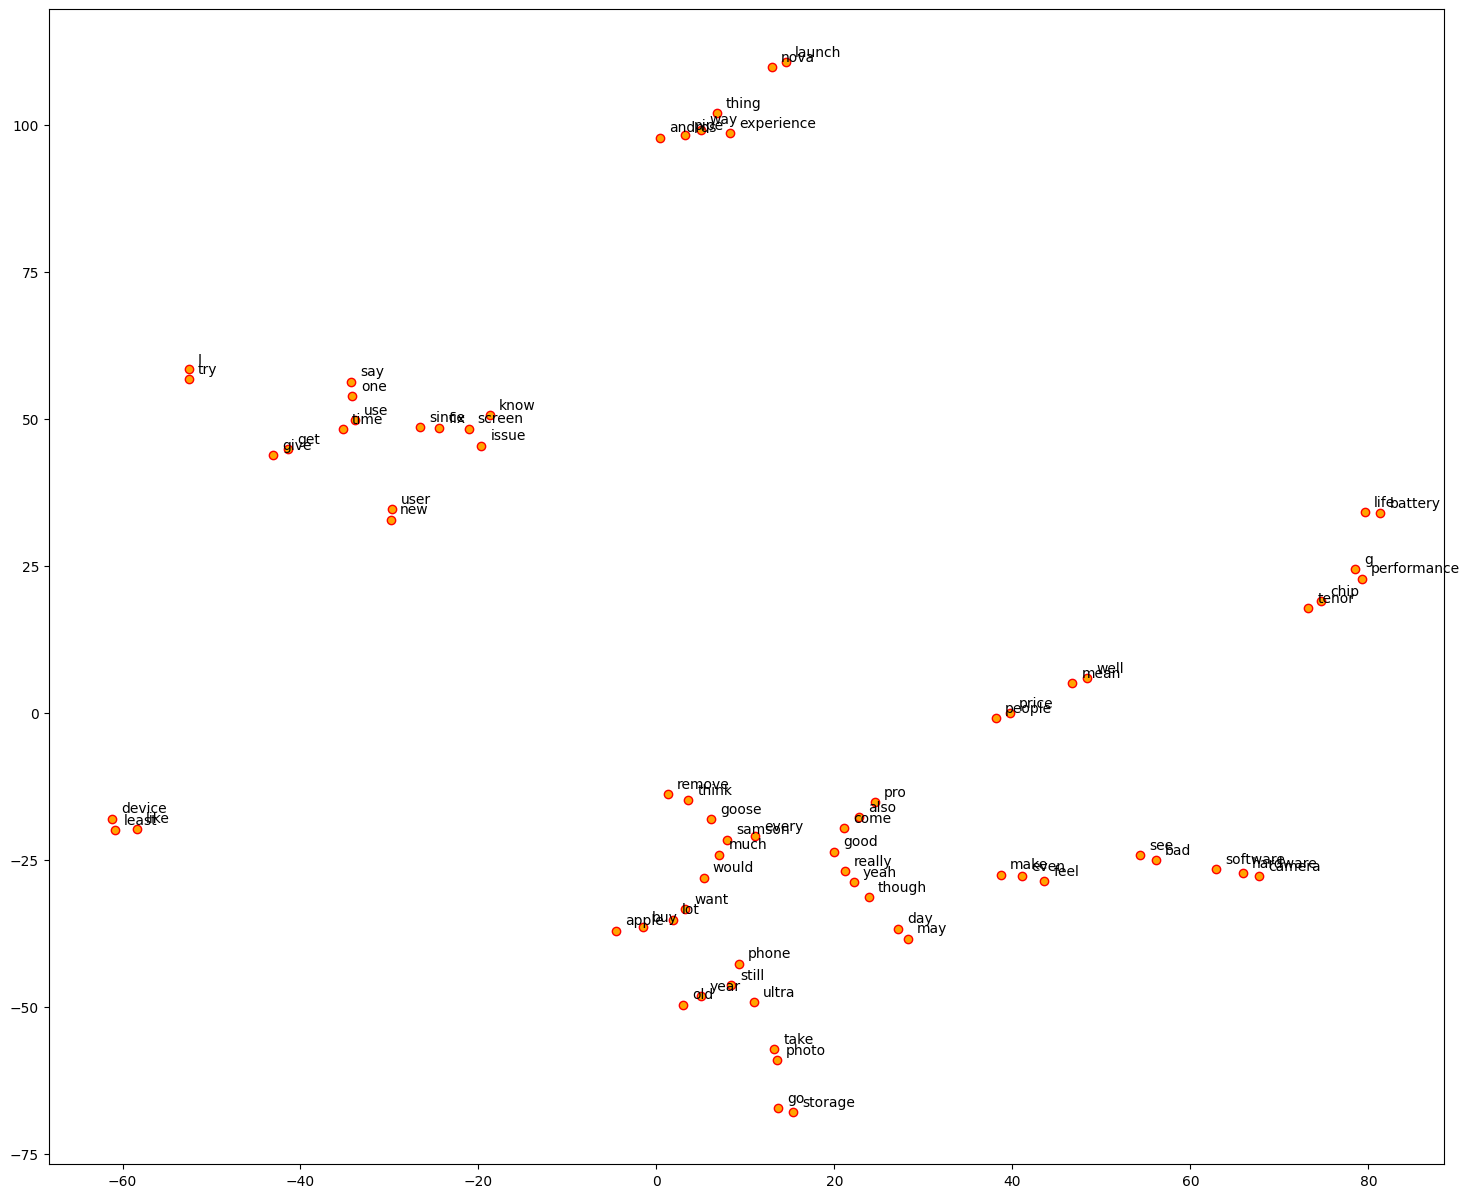

In [40]:
words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 15))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')

for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [41]:
# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model, num_features=feature_size)

In [42]:
ap = AffinityPropagation(max_iter=500, damping=0.7, random_state=None)
ap.fit(w2v_feature_array)
cluster_centers_indices = ap.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
df_cluster_word2vec = pd.concat([df, cluster_labels], axis=1)
df_cluster_word2vec.to_csv(f'../data/results/{file_name}_cluster_word2vec.csv')

print('Estimated number of cluster is {}'.format(n_clusters_))

Estimated number of cluster is 25


In [43]:
print('Text processing ended at {}'.format(datetime.now()))

Text processing ended at 2025-04-09 03:10:12.898752


In [44]:
df_cluster_word2vec.groupby(by="ClusterLabel")["ClusterLabel"].count().sort_values(ascending=False).reset_index(name="count")

,ClusterLabel,count
0,12,50
1,18,40
2,20,32
3,14,31
4,17,28
5,6,28
6,21,23
7,24,23
8,2,18
9,5,17


In [45]:
df_cluster_word2vec.sort_values(by="ClusterLabel")

,Comment ID,Comment Body,Author,Upvotes,Timestamp,Cleaned_Comment,ClusterLabel
3,m99kwtr,Snapdragon 8 elite blows google’s tensor out o...,porygon766,147,1.737900e+09,snapdragon elite blow gorge tenor water,0
218,m9gdkv9,This is how I feel too.\n\nThe new Tensor chip...,MrBadBadly,10,1.737987e+09,I feel new tenor chip fine fix pro go model ul...,1
228,m9f0dqn,"Tbf, Samsung builds the Google Tensors. Qualco...",jrs-kun,3,1.737962e+09,samson build goose tendon qualcom mediate sams...,1
229,mai5noc,It's definitely a weak spot but it's ironicall...,KilgoresPetTrout,1,1.738472e+09,definitely weak spot ironically use samson int...,1
396,m9ge5h0,Premium price premium expectations,Ok-Spend-337,2,1.737988e+09,premium price premium expectation,1
118,m9a4hui,Well if you are paying flagship money then peo...,killer-1o1,6,1.737906e+09,well pay flagship money people ought care,1
54,m9gbplz,"They say it's better every year, and that it's...",MrBadBadly,9,1.737987e+09,say well every year thank new chip old powerfu...,1
304,m9cm1zc,"Ah, another pixel fanboy justifying their expe...",Apple_The_Chicken,7,1.737932e+09,ah another fix fancy justify expensive yet mid...,1
285,mbg5vu2,">Google is working to upgrade Tensor, but the ...",ChiefIndica,1,1.738918e+09,goose work upgrade tenor major upgrade next ye...,1
106,m9brjr7,Pay more to get last year's phone?\n\nWith pre...,BetterDrinkMy0wnPiss,1,1.737923e+09,pay get last year phone recorder bone discount...,1
